# Group Number: 08
# Student 1: Jasper Linders (1259849)
# Student 2: Alexander Liu (1377973)
# Student 3: Sjoerd van Straten (1341642)


In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


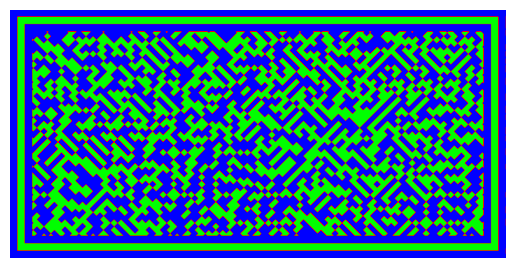

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
###     YOUR CODE FOR TASK 1    ###
from torch.utils.data import DataLoader

def plot_carpet(X):
    """ Helper function to plot the carpet by unit cells and super cells """
    # Plot the carpet
    plt.imshow(X.T, cmap='Greys')

    # Add vertical borders
    for i in range(15):
      plt.axhline(y=i*4-0.5, color='g', linestyle='-')
    for i in range(24):
      plt.axvline(x=i*4-0.5, color='g', linestyle='-')

    # Add horizontal borders
    for i in range(5):
      plt.axhline(y=i*4*3-0.5, color='r', linestyle='-')
    for i in range(8):
      plt.axvline(x=i*4*3-0.5, color='r', linestyle='-')

def loss_batch(model, loss_func, xb, yb, opt=None):
    """ Helper function to compute loss and corrects"""

    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    _, truth = torch.max(yb.data, 1)
    corrects = torch.sum(preds == truth)
    return loss.item(), corrects, len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """ Helper function to fit the model"""

    # Initialize lists to store the results
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in tqdm(range(epochs)):
        
        # Training
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # Forward and backward
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, opt)
            
            # Obtain loss and corrects
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # Validation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # Obtain loss and corrects
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # Compute the statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')
        
        # Add the results to the list
        train_losses.append(train_loss)
        train_accs.append(train_acc.item())
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())
    
    # Return the results
    return train_losses, train_accs, val_losses, val_accs

def get_data(train_ds, valid_ds, bs):
    """ Helper function to create dataloader """
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs),
    )


In [8]:
from torch import nn
from torch import optim
import torch.nn.functional as F

class symmetry_model(nn.Module):
    """ Symmetry architecture model"""
    def __init__(self):
        super().__init__()
        self.symslice = sc.Slice(rotation=4, reflection=False)
        self.symconv1 = sc.SymmetryConv2d(in_filters=1, out_filters=32, kernel_size=4, stride=4,\
                                         bias=True, rotation=4, reflection=False)
        self.symconv2 = sc.SymmetryConv2d(in_filters=32, out_filters=64, kernel_size=3, stride=3, \
                                         bias=True, rotation=4, reflection=False)
        self.sympool = sc.SymmetryPool(pool=torch.mean)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*8*5, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.symslice(x)
        x = F.relu(self.symconv1(x))
        x = F.relu(self.symconv2(x))
        x = self.sympool(x)
        x = self.batchnorm1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.batchnorm2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
# Check if gpu is available
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

def preprocess(x, y):
    # Put x and y to gpu if possible
    return x.to(dev), y.to(dev)


True


In [10]:
def plot_training(outp, epochs):
    # Intialize a list storing the epochs
    ep = [i+1 for i in range(epochs)]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle("Training evaluation plots")
    
    # Plot loss function
    ax1.plot(ep, outp[0], label='train')
    ax1.plot(ep, outp[2], label='validation')
    ax1.set_title('Loss function')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy scores
    ax2.plot(ep, outp[1], label='train')
    ax2.plot(ep, outp[3], label='validation')
    ax2.set_title('Accuracy score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
def evaluate_model(model, dl):
    """ Helper function used to evaluate the model on a dataloader"""
    # Validation
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in dl:
            
            # Obtain loss and corrects
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
            
            # Compute statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        # Update the statistics
        val_loss = running_loss / sample_num
        val_acc = running_corrects.double()/ sample_num

    return val_acc

  2%|▏         | 1/50 [00:11<09:05, 11.14s/it]

EPOCH: 01/50 LOSS: 1.1601 ACC: 0.5817  VAL-LOSS: 0.2006 VAL-ACC: 0.9380 


  4%|▍         | 2/50 [00:14<05:04,  6.35s/it]

EPOCH: 02/50 LOSS: 0.3065 ACC: 0.8819  VAL-LOSS: 0.0793 VAL-ACC: 0.9850 


  6%|▌         | 3/50 [00:17<03:47,  4.85s/it]

EPOCH: 03/50 LOSS: 0.1996 ACC: 0.9235  VAL-LOSS: 0.0556 VAL-ACC: 0.9870 


  8%|▊         | 4/50 [00:20<03:20,  4.36s/it]

EPOCH: 04/50 LOSS: 0.1872 ACC: 0.9312  VAL-LOSS: 0.0536 VAL-ACC: 0.9860 


 10%|█         | 5/50 [00:24<02:57,  3.94s/it]

EPOCH: 05/50 LOSS: 0.1570 ACC: 0.9408  VAL-LOSS: 0.0349 VAL-ACC: 0.9940 


 12%|█▏        | 6/50 [00:27<02:39,  3.63s/it]

EPOCH: 06/50 LOSS: 0.1446 ACC: 0.9501  VAL-LOSS: 0.0306 VAL-ACC: 0.9940 


 14%|█▍        | 7/50 [00:30<02:27,  3.43s/it]

EPOCH: 07/50 LOSS: 0.1348 ACC: 0.9511  VAL-LOSS: 0.0240 VAL-ACC: 0.9965 


 16%|█▌        | 8/50 [00:33<02:25,  3.46s/it]

EPOCH: 08/50 LOSS: 0.1252 ACC: 0.9573  VAL-LOSS: 0.0367 VAL-ACC: 0.9915 


 18%|█▊        | 9/50 [00:36<02:20,  3.42s/it]

EPOCH: 09/50 LOSS: 0.1210 ACC: 0.9565  VAL-LOSS: 0.0242 VAL-ACC: 0.9995 


 20%|██        | 10/50 [00:39<02:11,  3.29s/it]

EPOCH: 10/50 LOSS: 0.1180 ACC: 0.9563  VAL-LOSS: 0.0195 VAL-ACC: 0.9965 


 22%|██▏       | 11/50 [00:43<02:06,  3.24s/it]

EPOCH: 11/50 LOSS: 0.1187 ACC: 0.9569  VAL-LOSS: 0.0234 VAL-ACC: 0.9915 


 24%|██▍       | 12/50 [00:46<02:04,  3.28s/it]

EPOCH: 12/50 LOSS: 0.1139 ACC: 0.9608  VAL-LOSS: 0.0198 VAL-ACC: 0.9940 


 26%|██▌       | 13/50 [00:49<02:03,  3.33s/it]

EPOCH: 13/50 LOSS: 0.0937 ACC: 0.9675  VAL-LOSS: 0.0139 VAL-ACC: 0.9960 


 28%|██▊       | 14/50 [00:52<01:56,  3.23s/it]

EPOCH: 14/50 LOSS: 0.1119 ACC: 0.9637  VAL-LOSS: 0.0152 VAL-ACC: 0.9980 


 30%|███       | 15/50 [00:56<01:57,  3.36s/it]

EPOCH: 15/50 LOSS: 0.1161 ACC: 0.9625  VAL-LOSS: 0.0164 VAL-ACC: 0.9965 


 32%|███▏      | 16/50 [01:00<01:58,  3.48s/it]

EPOCH: 16/50 LOSS: 0.0990 ACC: 0.9649  VAL-LOSS: 0.0116 VAL-ACC: 0.9985 


 34%|███▍      | 17/50 [01:03<01:54,  3.46s/it]

EPOCH: 17/50 LOSS: 0.1011 ACC: 0.9663  VAL-LOSS: 0.0113 VAL-ACC: 0.9955 


 36%|███▌      | 18/50 [01:06<01:48,  3.38s/it]

EPOCH: 18/50 LOSS: 0.1067 ACC: 0.9616  VAL-LOSS: 0.0141 VAL-ACC: 0.9970 


 38%|███▊      | 19/50 [01:09<01:41,  3.27s/it]

EPOCH: 19/50 LOSS: 0.1228 ACC: 0.9601  VAL-LOSS: 0.0168 VAL-ACC: 0.9955 


 40%|████      | 20/50 [01:13<01:39,  3.31s/it]

EPOCH: 20/50 LOSS: 0.0909 ACC: 0.9683  VAL-LOSS: 0.0204 VAL-ACC: 0.9930 


 42%|████▏     | 21/50 [01:16<01:36,  3.34s/it]

EPOCH: 21/50 LOSS: 0.0853 ACC: 0.9737  VAL-LOSS: 0.0126 VAL-ACC: 0.9970 


 44%|████▍     | 22/50 [01:19<01:30,  3.25s/it]

EPOCH: 22/50 LOSS: 0.0714 ACC: 0.9737  VAL-LOSS: 0.0062 VAL-ACC: 0.9985 


 46%|████▌     | 23/50 [01:22<01:26,  3.19s/it]

EPOCH: 23/50 LOSS: 0.0727 ACC: 0.9773  VAL-LOSS: 0.0061 VAL-ACC: 0.9995 


 48%|████▊     | 24/50 [01:26<01:23,  3.22s/it]

EPOCH: 24/50 LOSS: 0.0785 ACC: 0.9741  VAL-LOSS: 0.0141 VAL-ACC: 0.9960 


 50%|█████     | 25/50 [01:29<01:22,  3.30s/it]

EPOCH: 25/50 LOSS: 0.0828 ACC: 0.9727  VAL-LOSS: 0.0099 VAL-ACC: 0.9955 


 52%|█████▏    | 26/50 [01:32<01:16,  3.20s/it]

EPOCH: 26/50 LOSS: 0.0965 ACC: 0.9699  VAL-LOSS: 0.0065 VAL-ACC: 0.9980 


 54%|█████▍    | 27/50 [01:35<01:12,  3.17s/it]

EPOCH: 27/50 LOSS: 0.0840 ACC: 0.9737  VAL-LOSS: 0.0085 VAL-ACC: 0.9985 


 56%|█████▌    | 28/50 [01:38<01:09,  3.14s/it]

EPOCH: 28/50 LOSS: 0.0639 ACC: 0.9776  VAL-LOSS: 0.0139 VAL-ACC: 0.9985 


 58%|█████▊    | 29/50 [01:42<01:09,  3.31s/it]

EPOCH: 29/50 LOSS: 0.0571 ACC: 0.9809  VAL-LOSS: 0.0081 VAL-ACC: 0.9980 


 60%|██████    | 30/50 [01:45<01:04,  3.23s/it]

EPOCH: 30/50 LOSS: 0.0735 ACC: 0.9772  VAL-LOSS: 0.0202 VAL-ACC: 0.9975 


 62%|██████▏   | 31/50 [01:48<01:00,  3.18s/it]

EPOCH: 31/50 LOSS: 0.0771 ACC: 0.9777  VAL-LOSS: 0.0078 VAL-ACC: 0.9975 


 64%|██████▍   | 32/50 [01:51<00:56,  3.13s/it]

EPOCH: 32/50 LOSS: 0.0694 ACC: 0.9769  VAL-LOSS: 0.0066 VAL-ACC: 0.9990 


 66%|██████▌   | 33/50 [01:55<00:56,  3.31s/it]

EPOCH: 33/50 LOSS: 0.0739 ACC: 0.9752  VAL-LOSS: 0.0042 VAL-ACC: 0.9995 


 68%|██████▊   | 34/50 [01:58<00:51,  3.22s/it]

EPOCH: 34/50 LOSS: 0.0625 ACC: 0.9783  VAL-LOSS: 0.0027 VAL-ACC: 1.0000 


 70%|███████   | 35/50 [02:01<00:47,  3.16s/it]

EPOCH: 35/50 LOSS: 0.0796 ACC: 0.9756  VAL-LOSS: 0.0072 VAL-ACC: 0.9985 


 72%|███████▏  | 36/50 [02:04<00:43,  3.13s/it]

EPOCH: 36/50 LOSS: 0.0712 ACC: 0.9773  VAL-LOSS: 0.0070 VAL-ACC: 0.9990 


 74%|███████▍  | 37/50 [02:08<00:42,  3.29s/it]

EPOCH: 37/50 LOSS: 0.0791 ACC: 0.9752  VAL-LOSS: 0.0088 VAL-ACC: 0.9975 


 76%|███████▌  | 38/50 [02:11<00:38,  3.24s/it]

EPOCH: 38/50 LOSS: 0.0628 ACC: 0.9805  VAL-LOSS: 0.0061 VAL-ACC: 0.9985 


 78%|███████▊  | 39/50 [02:14<00:34,  3.17s/it]

EPOCH: 39/50 LOSS: 0.0761 ACC: 0.9781  VAL-LOSS: 0.0056 VAL-ACC: 0.9990 


 80%|████████  | 40/50 [02:17<00:31,  3.12s/it]

EPOCH: 40/50 LOSS: 0.0590 ACC: 0.9800  VAL-LOSS: 0.0069 VAL-ACC: 0.9985 


 82%|████████▏ | 41/50 [02:20<00:29,  3.24s/it]

EPOCH: 41/50 LOSS: 0.0679 ACC: 0.9803  VAL-LOSS: 0.0048 VAL-ACC: 0.9990 


 84%|████████▍ | 42/50 [02:23<00:25,  3.23s/it]

EPOCH: 42/50 LOSS: 0.0488 ACC: 0.9845  VAL-LOSS: 0.0038 VAL-ACC: 0.9995 


 86%|████████▌ | 43/50 [02:26<00:22,  3.17s/it]

EPOCH: 43/50 LOSS: 0.0559 ACC: 0.9833  VAL-LOSS: 0.0042 VAL-ACC: 0.9990 


 88%|████████▊ | 44/50 [02:29<00:18,  3.11s/it]

EPOCH: 44/50 LOSS: 0.0566 ACC: 0.9817  VAL-LOSS: 0.0022 VAL-ACC: 1.0000 


 90%|█████████ | 45/50 [02:33<00:15,  3.18s/it]

EPOCH: 45/50 LOSS: 0.0556 ACC: 0.9823  VAL-LOSS: 0.0098 VAL-ACC: 0.9985 


 92%|█████████▏| 46/50 [02:36<00:13,  3.27s/it]

EPOCH: 46/50 LOSS: 0.0585 ACC: 0.9829  VAL-LOSS: 0.0056 VAL-ACC: 0.9980 


 94%|█████████▍| 47/50 [02:39<00:09,  3.19s/it]

EPOCH: 47/50 LOSS: 0.0660 ACC: 0.9796  VAL-LOSS: 0.0259 VAL-ACC: 0.9975 


 96%|█████████▌| 48/50 [02:42<00:06,  3.14s/it]

EPOCH: 48/50 LOSS: 0.0555 ACC: 0.9828  VAL-LOSS: 0.0027 VAL-ACC: 0.9995 


 98%|█████████▊| 49/50 [02:45<00:03,  3.17s/it]

EPOCH: 49/50 LOSS: 0.0739 ACC: 0.9801  VAL-LOSS: 0.0142 VAL-ACC: 0.9985 


100%|██████████| 50/50 [02:49<00:00,  3.39s/it]

EPOCH: 50/50 LOSS: 0.0471 ACC: 0.9847  VAL-LOSS: 0.0051 VAL-ACC: 0.9990 


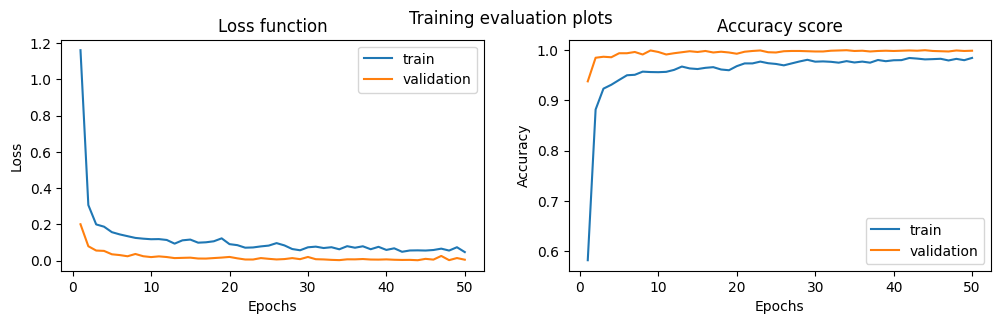

In [11]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)
torch.backends.cudnn.deterministic=True

# Initialize parameters
epochs = 50
lr = 0.01
bs = 16

# Create dataloader 
train_dl, valid_dl = get_data(train_dataset, val_dataset, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

# Initialize model and use gpu if possible
model = symmetry_model()
model.to(dev)

opt = optim.Adam(model.parameters(), lr=lr)
loss_func = F.cross_entropy

# Fit the model
outp = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Plot the results
plot_training(outp, epochs)

In [12]:
# Save the model
torch.save(model.state_dict(), 'final_checkpoint.pth')

# Load the model and use gpu if possible
model = symmetry_model()
model.load_state_dict(torch.load('final_checkpoint.pth'))
model.to(dev)

symmetry_model(
  (symslice): Slice()
  (symconv1): SymmetryConv2d()
  (symconv2): SymmetryConv2d()
  (sympool): SymmetryPool()
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2560, out_features=1024, bias=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
# Initialize dataloaders for evaluation
train_dl = DataLoader(train_dataset, 1, shuffle=False)
val_dl = DataLoader(val_dataset, 1, shuffle=False)
test_dl = DataLoader(test_dataset, 1, shuffle=False)

train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

# Evaluate
print("Accuracy on train data", evaluate_model(model, train_dl).item())
print("Accuracy on validation data", evaluate_model(model, val_dl).item())
print("Accuracy on test data", evaluate_model(model, test_dl).item())

Accuracy on train data 0.9994666666666667
Accuracy on validation data 0.999
Accuracy on test data 0.998


## Task 1: Question 5d

In [14]:
class symmetry_model_1(nn.Module):
    """ Uses amax instead avg when pooling""" 
    def __init__(self):
        super().__init__()
        self.symslice = sc.Slice(rotation=4, reflection=False)
        self.symconv1 = sc.SymmetryConv2d(in_filters=1, out_filters=32, kernel_size=4, stride=4,\
                                         bias=True, rotation=4, reflection=False)
        self.symconv2 = sc.SymmetryConv2d(in_filters=32, out_filters=64, kernel_size=3, stride=3, \
                                         bias=True, rotation=4, reflection=False)
        self.sympool = sc.SymmetryPool(pool=torch.amax)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*8*5, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.symslice(x)
        x = F.relu(self.symconv1(x))
        x = F.relu(self.symconv2(x))
        x = self.sympool(x)
        x = self.batchnorm1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.batchnorm2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class symmetry_model_2(nn.Module):
    """ No regularization methods (batch normalization and dropout)  """ 

    def __init__(self):
        super().__init__()
        self.symslice = sc.Slice(rotation=4, reflection=False)
        self.symconv1 = sc.SymmetryConv2d(in_filters=1, out_filters=32, kernel_size=4, stride=4,\
                                         bias=True, rotation=4, reflection=False)
        self.symconv2 = sc.SymmetryConv2d(in_filters=32, out_filters=64, kernel_size=3, stride=3, \
                                         bias=True, rotation=4, reflection=False)
        self.sympool = sc.SymmetryPool(pool=torch.mean)
        self.fc1 = nn.Linear(64*8*5, 1024)
        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.symslice(x)
        x = F.relu(self.symconv1(x))
        x = F.relu(self.symconv2(x))
        x = self.sympool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class symmetry_model_3(nn.Module):
    """ No bias in SymmetryConv2d""" 
    def __init__(self):
        super().__init__()
        self.symslice = sc.Slice(rotation=4, reflection=False)
        self.symconv1 = sc.SymmetryConv2d(in_filters=1, out_filters=32, kernel_size=4, stride=4,\
                                         bias=False, rotation=4, reflection=False)
        self.symconv2 = sc.SymmetryConv2d(in_filters=32, out_filters=64, kernel_size=3, stride=3, \
                                         bias=False, rotation=4, reflection=False)
        self.sympool = sc.SymmetryPool(pool=torch.mean)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*8*5, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.symslice(x)
        x = F.relu(self.symconv1(x))
        x = F.relu(self.symconv2(x))
        x = self.sympool(x)
        x = self.batchnorm1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.batchnorm2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

  2%|▏         | 1/50 [00:03<02:50,  3.47s/it]

EPOCH: 01/50 LOSS: 1.1551 ACC: 0.5871  VAL-LOSS: 0.1516 VAL-ACC: 0.9590 


  4%|▍         | 2/50 [00:06<02:42,  3.39s/it]

EPOCH: 02/50 LOSS: 0.2676 ACC: 0.8972  VAL-LOSS: 0.0932 VAL-ACC: 0.9700 


  6%|▌         | 3/50 [00:09<02:32,  3.24s/it]

EPOCH: 03/50 LOSS: 0.2105 ACC: 0.9243  VAL-LOSS: 0.0619 VAL-ACC: 0.9810 


  8%|▊         | 4/50 [00:12<02:25,  3.16s/it]

EPOCH: 04/50 LOSS: 0.1680 ACC: 0.9379  VAL-LOSS: 0.0322 VAL-ACC: 0.9920 


 10%|█         | 5/50 [00:16<02:25,  3.23s/it]

EPOCH: 05/50 LOSS: 0.1445 ACC: 0.9463  VAL-LOSS: 0.0572 VAL-ACC: 0.9820 


 12%|█▏        | 6/50 [00:19<02:25,  3.32s/it]

EPOCH: 06/50 LOSS: 0.1438 ACC: 0.9471  VAL-LOSS: 0.0264 VAL-ACC: 0.9935 


 14%|█▍        | 7/50 [00:22<02:18,  3.22s/it]

EPOCH: 07/50 LOSS: 0.1295 ACC: 0.9532  VAL-LOSS: 0.0257 VAL-ACC: 0.9935 


 16%|█▌        | 8/50 [00:25<02:12,  3.16s/it]

EPOCH: 08/50 LOSS: 0.1354 ACC: 0.9515  VAL-LOSS: 0.0359 VAL-ACC: 0.9940 


 18%|█▊        | 9/50 [00:29<02:10,  3.18s/it]

EPOCH: 09/50 LOSS: 0.1199 ACC: 0.9584  VAL-LOSS: 0.0240 VAL-ACC: 0.9940 


 20%|██        | 10/50 [00:32<02:12,  3.31s/it]

EPOCH: 10/50 LOSS: 0.1036 ACC: 0.9619  VAL-LOSS: 0.0273 VAL-ACC: 0.9910 


 22%|██▏       | 11/50 [00:35<02:05,  3.23s/it]

EPOCH: 11/50 LOSS: 0.1355 ACC: 0.9551  VAL-LOSS: 0.0262 VAL-ACC: 0.9925 


 24%|██▍       | 12/50 [00:38<02:00,  3.17s/it]

EPOCH: 12/50 LOSS: 0.1011 ACC: 0.9652  VAL-LOSS: 0.0242 VAL-ACC: 0.9935 


 26%|██▌       | 13/50 [00:41<01:56,  3.14s/it]

EPOCH: 13/50 LOSS: 0.1082 ACC: 0.9619  VAL-LOSS: 0.0455 VAL-ACC: 0.9940 


 28%|██▊       | 14/50 [00:45<01:59,  3.33s/it]

EPOCH: 14/50 LOSS: 0.1110 ACC: 0.9628  VAL-LOSS: 0.0251 VAL-ACC: 0.9930 


 30%|███       | 15/50 [00:48<01:53,  3.25s/it]

EPOCH: 15/50 LOSS: 0.1008 ACC: 0.9649  VAL-LOSS: 0.0176 VAL-ACC: 0.9955 


 32%|███▏      | 16/50 [00:51<01:48,  3.19s/it]

EPOCH: 16/50 LOSS: 0.1130 ACC: 0.9667  VAL-LOSS: 0.0556 VAL-ACC: 0.9895 


 34%|███▍      | 17/50 [00:54<01:43,  3.15s/it]

EPOCH: 17/50 LOSS: 0.0843 ACC: 0.9693  VAL-LOSS: 0.0263 VAL-ACC: 0.9920 


 36%|███▌      | 18/50 [00:58<01:47,  3.35s/it]

EPOCH: 18/50 LOSS: 0.0900 ACC: 0.9692  VAL-LOSS: 0.0265 VAL-ACC: 0.9935 


 38%|███▊      | 19/50 [01:01<01:40,  3.26s/it]

EPOCH: 19/50 LOSS: 0.1056 ACC: 0.9632  VAL-LOSS: 0.0815 VAL-ACC: 0.9900 


 40%|████      | 20/50 [01:04<01:35,  3.19s/it]

EPOCH: 20/50 LOSS: 0.0886 ACC: 0.9695  VAL-LOSS: 0.0174 VAL-ACC: 0.9965 


 42%|████▏     | 21/50 [01:07<01:31,  3.15s/it]

EPOCH: 21/50 LOSS: 0.0771 ACC: 0.9735  VAL-LOSS: 0.0509 VAL-ACC: 0.9900 


 44%|████▍     | 22/50 [01:11<01:33,  3.33s/it]

EPOCH: 22/50 LOSS: 0.0878 ACC: 0.9727  VAL-LOSS: 0.0192 VAL-ACC: 0.9935 


 46%|████▌     | 23/50 [01:14<01:28,  3.28s/it]

EPOCH: 23/50 LOSS: 0.0848 ACC: 0.9716  VAL-LOSS: 0.0198 VAL-ACC: 0.9935 


 48%|████▊     | 24/50 [01:17<01:23,  3.21s/it]

EPOCH: 24/50 LOSS: 0.0874 ACC: 0.9692  VAL-LOSS: 0.0158 VAL-ACC: 0.9950 


 50%|█████     | 25/50 [01:20<01:19,  3.17s/it]

EPOCH: 25/50 LOSS: 0.0859 ACC: 0.9741  VAL-LOSS: 0.0220 VAL-ACC: 0.9900 


 52%|█████▏    | 26/50 [01:24<01:18,  3.29s/it]

EPOCH: 26/50 LOSS: 0.0827 ACC: 0.9744  VAL-LOSS: 0.3181 VAL-ACC: 0.9925 


 54%|█████▍    | 27/50 [01:27<01:15,  3.28s/it]

EPOCH: 27/50 LOSS: 0.0787 ACC: 0.9751  VAL-LOSS: 0.0162 VAL-ACC: 0.9965 


 56%|█████▌    | 28/50 [01:30<01:11,  3.23s/it]

EPOCH: 28/50 LOSS: 0.0675 ACC: 0.9733  VAL-LOSS: 0.0283 VAL-ACC: 0.9940 


 58%|█████▊    | 29/50 [01:33<01:06,  3.18s/it]

EPOCH: 29/50 LOSS: 0.0773 ACC: 0.9752  VAL-LOSS: 0.1986 VAL-ACC: 0.9930 


 60%|██████    | 30/50 [01:37<01:05,  3.30s/it]

EPOCH: 30/50 LOSS: 0.0833 ACC: 0.9731  VAL-LOSS: 0.0376 VAL-ACC: 0.9950 


 62%|██████▏   | 31/50 [01:40<01:02,  3.30s/it]

EPOCH: 31/50 LOSS: 0.0767 ACC: 0.9741  VAL-LOSS: 0.0147 VAL-ACC: 0.9950 


 64%|██████▍   | 32/50 [01:43<00:58,  3.23s/it]

EPOCH: 32/50 LOSS: 0.0902 ACC: 0.9753  VAL-LOSS: 0.0180 VAL-ACC: 0.9925 


 66%|██████▌   | 33/50 [01:46<00:54,  3.18s/it]

EPOCH: 33/50 LOSS: 0.0820 ACC: 0.9729  VAL-LOSS: 0.0171 VAL-ACC: 0.9945 


 68%|██████▊   | 34/50 [01:50<00:51,  3.25s/it]

EPOCH: 34/50 LOSS: 0.0776 ACC: 0.9760  VAL-LOSS: 0.0137 VAL-ACC: 0.9965 


 70%|███████   | 35/50 [01:53<00:49,  3.30s/it]

EPOCH: 35/50 LOSS: 0.0829 ACC: 0.9745  VAL-LOSS: 0.0129 VAL-ACC: 0.9980 


 72%|███████▏  | 36/50 [01:56<00:45,  3.23s/it]

EPOCH: 36/50 LOSS: 0.0789 ACC: 0.9743  VAL-LOSS: 0.0147 VAL-ACC: 0.9960 


 74%|███████▍  | 37/50 [01:59<00:41,  3.18s/it]

EPOCH: 37/50 LOSS: 0.0769 ACC: 0.9773  VAL-LOSS: 0.0198 VAL-ACC: 0.9955 


 76%|███████▌  | 38/50 [02:02<00:38,  3.22s/it]

EPOCH: 38/50 LOSS: 0.0685 ACC: 0.9772  VAL-LOSS: 0.0132 VAL-ACC: 0.9960 


 78%|███████▊  | 39/50 [02:06<00:36,  3.32s/it]

EPOCH: 39/50 LOSS: 0.0563 ACC: 0.9813  VAL-LOSS: 0.0159 VAL-ACC: 0.9960 


 80%|████████  | 40/50 [02:09<00:32,  3.24s/it]

EPOCH: 40/50 LOSS: 0.0662 ACC: 0.9759  VAL-LOSS: 0.0142 VAL-ACC: 0.9960 


 82%|████████▏ | 41/50 [02:12<00:28,  3.19s/it]

EPOCH: 41/50 LOSS: 0.0780 ACC: 0.9764  VAL-LOSS: 0.0139 VAL-ACC: 0.9945 


 84%|████████▍ | 42/50 [02:15<00:25,  3.20s/it]

EPOCH: 42/50 LOSS: 0.0602 ACC: 0.9808  VAL-LOSS: 0.0133 VAL-ACC: 0.9950 


 86%|████████▌ | 43/50 [02:19<00:23,  3.32s/it]

EPOCH: 43/50 LOSS: 0.0753 ACC: 0.9768  VAL-LOSS: 0.0145 VAL-ACC: 0.9965 


 88%|████████▊ | 44/50 [02:22<00:19,  3.24s/it]

EPOCH: 44/50 LOSS: 0.0696 ACC: 0.9773  VAL-LOSS: 0.3049 VAL-ACC: 0.9935 


 90%|█████████ | 45/50 [02:25<00:15,  3.18s/it]

EPOCH: 45/50 LOSS: 0.0586 ACC: 0.9813  VAL-LOSS: 0.0112 VAL-ACC: 0.9965 


 92%|█████████▏| 46/50 [02:28<00:12,  3.16s/it]

EPOCH: 46/50 LOSS: 0.0963 ACC: 0.9736  VAL-LOSS: 0.0651 VAL-ACC: 0.9940 


 94%|█████████▍| 47/50 [02:32<00:10,  3.35s/it]

EPOCH: 47/50 LOSS: 0.0768 ACC: 0.9767  VAL-LOSS: 0.0108 VAL-ACC: 0.9975 


 96%|█████████▌| 48/50 [02:35<00:06,  3.28s/it]

EPOCH: 48/50 LOSS: 0.0581 ACC: 0.9796  VAL-LOSS: 0.0071 VAL-ACC: 0.9995 


 98%|█████████▊| 49/50 [02:38<00:03,  3.22s/it]

EPOCH: 49/50 LOSS: 0.0625 ACC: 0.9797  VAL-LOSS: 0.0094 VAL-ACC: 0.9965 


100%|██████████| 50/50 [02:41<00:00,  3.24s/it]

EPOCH: 50/50 LOSS: 0.0553 ACC: 0.9825  VAL-LOSS: 0.0202 VAL-ACC: 0.9945 


Accuracy on train data 0.9961333333333334
Accuracy on validation data 0.9945
Accuracy on test data 0.996


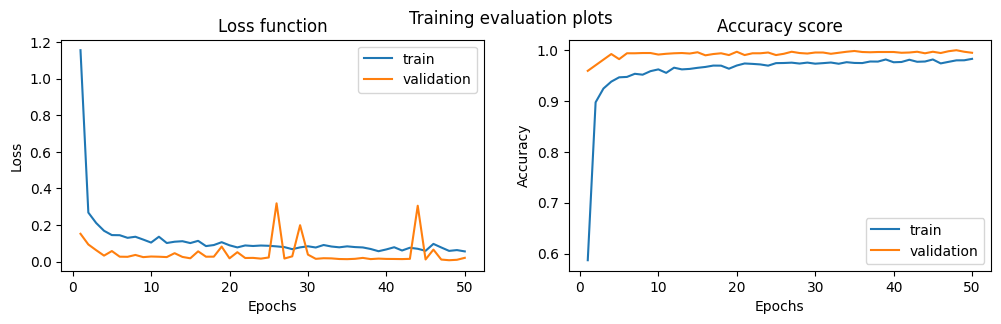

In [15]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)
torch.backends.cudnn.deterministic=True

# Initialize parameters
epochs = 50
lr = 0.01
bs = 16

# Create data loaders
train_dl, valid_dl = get_data(train_dataset, val_dataset, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

# Initialize model and use gpu if possible
model = symmetry_model_1()
model.to(dev)

opt = optim.Adam(model.parameters(), lr=lr)
loss_func = F.cross_entropy

# Fit the model
outp = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Plot the output
plot_training(outp, epochs)

# Evaluate the performance 
train_dl = DataLoader(train_dataset, 1, shuffle=False)
val_dl = DataLoader(val_dataset, 1, shuffle=False)
test_dl = DataLoader(test_dataset, 1, shuffle=False)

train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

print("Accuracy on train data", evaluate_model(model, train_dl).item())
print("Accuracy on validation data", evaluate_model(model, val_dl).item())
print("Accuracy on test data", evaluate_model(model, test_dl).item())

  2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

EPOCH: 01/50 LOSS: 14.6998 ACC: 0.3525  VAL-LOSS: 1.0614 VAL-ACC: 0.4250 


  4%|▍         | 2/50 [00:05<02:17,  2.86s/it]

EPOCH: 02/50 LOSS: 0.8031 ACC: 0.6273  VAL-LOSS: 0.4525 VAL-ACC: 0.8015 


  6%|▌         | 3/50 [00:09<02:24,  3.08s/it]

EPOCH: 03/50 LOSS: 0.2608 ACC: 0.8981  VAL-LOSS: 0.3103 VAL-ACC: 0.8830 


  8%|▊         | 4/50 [00:12<02:22,  3.10s/it]

EPOCH: 04/50 LOSS: 0.1384 ACC: 0.9501  VAL-LOSS: 0.1977 VAL-ACC: 0.9240 


 10%|█         | 5/50 [00:15<02:15,  3.01s/it]

EPOCH: 05/50 LOSS: 0.1038 ACC: 0.9651  VAL-LOSS: 0.2776 VAL-ACC: 0.9040 


 12%|█▏        | 6/50 [00:17<02:09,  2.95s/it]

EPOCH: 06/50 LOSS: 0.0783 ACC: 0.9731  VAL-LOSS: 0.2900 VAL-ACC: 0.9100 


 14%|█▍        | 7/50 [00:20<02:06,  2.95s/it]

EPOCH: 07/50 LOSS: 0.1164 ACC: 0.9625  VAL-LOSS: 0.1054 VAL-ACC: 0.9630 


 16%|█▌        | 8/50 [00:24<02:09,  3.09s/it]

EPOCH: 08/50 LOSS: 0.0895 ACC: 0.9695  VAL-LOSS: 0.0904 VAL-ACC: 0.9685 


 18%|█▊        | 9/50 [00:27<02:03,  3.01s/it]

EPOCH: 09/50 LOSS: 0.0623 ACC: 0.9777  VAL-LOSS: 0.1491 VAL-ACC: 0.9560 


 20%|██        | 10/50 [00:29<01:57,  2.95s/it]

EPOCH: 10/50 LOSS: 0.1222 ACC: 0.9641  VAL-LOSS: 0.2868 VAL-ACC: 0.9355 


 22%|██▏       | 11/50 [00:32<01:53,  2.92s/it]

EPOCH: 11/50 LOSS: 0.1575 ACC: 0.9555  VAL-LOSS: 0.0959 VAL-ACC: 0.9705 


 24%|██▍       | 12/50 [00:36<01:56,  3.06s/it]

EPOCH: 12/50 LOSS: 0.1609 ACC: 0.9495  VAL-LOSS: 0.1148 VAL-ACC: 0.9590 


 26%|██▌       | 13/50 [00:40<02:10,  3.52s/it]

EPOCH: 13/50 LOSS: 0.2491 ACC: 0.9159  VAL-LOSS: 0.2239 VAL-ACC: 0.9075 


 28%|██▊       | 14/50 [00:44<02:09,  3.58s/it]

EPOCH: 14/50 LOSS: 0.1535 ACC: 0.9429  VAL-LOSS: 0.1634 VAL-ACC: 0.9550 


 30%|███       | 15/50 [00:47<01:58,  3.38s/it]

EPOCH: 15/50 LOSS: 0.1313 ACC: 0.9608  VAL-LOSS: 0.2375 VAL-ACC: 0.9330 


 32%|███▏      | 16/50 [00:50<01:56,  3.43s/it]

EPOCH: 16/50 LOSS: 0.2113 ACC: 0.9383  VAL-LOSS: 0.2717 VAL-ACC: 0.9200 


 34%|███▍      | 17/50 [00:53<01:47,  3.27s/it]

EPOCH: 17/50 LOSS: 0.1740 ACC: 0.9503  VAL-LOSS: 0.1139 VAL-ACC: 0.9645 


 36%|███▌      | 18/50 [00:56<01:41,  3.17s/it]

EPOCH: 18/50 LOSS: 0.1360 ACC: 0.9529  VAL-LOSS: 0.4935 VAL-ACC: 0.9575 


 38%|███▊      | 19/50 [01:03<02:07,  4.13s/it]

EPOCH: 19/50 LOSS: 0.1472 ACC: 0.9517  VAL-LOSS: 0.0905 VAL-ACC: 0.9580 


 40%|████      | 20/50 [01:06<02:02,  4.07s/it]

EPOCH: 20/50 LOSS: 0.2079 ACC: 0.9337  VAL-LOSS: 0.7459 VAL-ACC: 0.8685 


 42%|████▏     | 21/50 [01:10<01:57,  4.04s/it]

EPOCH: 21/50 LOSS: 0.2877 ACC: 0.8964  VAL-LOSS: 0.1429 VAL-ACC: 0.9375 


 44%|████▍     | 22/50 [01:13<01:42,  3.66s/it]

EPOCH: 22/50 LOSS: 0.1569 ACC: 0.9427  VAL-LOSS: 0.1191 VAL-ACC: 0.9620 


 46%|████▌     | 23/50 [01:17<01:36,  3.59s/it]

EPOCH: 23/50 LOSS: 0.1566 ACC: 0.9529  VAL-LOSS: 0.0784 VAL-ACC: 0.9630 


 48%|████▊     | 24/50 [01:20<01:34,  3.62s/it]

EPOCH: 24/50 LOSS: 0.1132 ACC: 0.9547  VAL-LOSS: 0.3469 VAL-ACC: 0.8680 


 50%|█████     | 25/50 [01:25<01:35,  3.82s/it]

EPOCH: 25/50 LOSS: 0.2763 ACC: 0.8893  VAL-LOSS: 0.2230 VAL-ACC: 0.8690 


 52%|█████▏    | 26/50 [01:28<01:26,  3.62s/it]

EPOCH: 26/50 LOSS: 0.2075 ACC: 0.9260  VAL-LOSS: 0.3373 VAL-ACC: 0.8805 


 54%|█████▍    | 27/50 [01:31<01:22,  3.57s/it]

EPOCH: 27/50 LOSS: 0.2285 ACC: 0.9077  VAL-LOSS: 0.1086 VAL-ACC: 0.9315 


 56%|█████▌    | 28/50 [01:34<01:13,  3.35s/it]

EPOCH: 28/50 LOSS: 0.0994 ACC: 0.9568  VAL-LOSS: 0.1262 VAL-ACC: 0.9340 


 58%|█████▊    | 29/50 [01:38<01:11,  3.41s/it]

EPOCH: 29/50 LOSS: 0.1055 ACC: 0.9633  VAL-LOSS: 0.0803 VAL-ACC: 0.9855 


 60%|██████    | 30/50 [01:40<01:04,  3.23s/it]

EPOCH: 30/50 LOSS: 0.0835 ACC: 0.9741  VAL-LOSS: 0.1144 VAL-ACC: 0.9710 


 62%|██████▏   | 31/50 [01:44<01:02,  3.31s/it]

EPOCH: 31/50 LOSS: 0.1358 ACC: 0.9540  VAL-LOSS: 0.1066 VAL-ACC: 0.9585 


 64%|██████▍   | 32/50 [01:48<01:01,  3.43s/it]

EPOCH: 32/50 LOSS: 0.0855 ACC: 0.9604  VAL-LOSS: 0.0500 VAL-ACC: 0.9750 


 66%|██████▌   | 33/50 [01:51<00:59,  3.49s/it]

EPOCH: 33/50 LOSS: 0.0634 ACC: 0.9771  VAL-LOSS: 0.0639 VAL-ACC: 0.9715 


 68%|██████▊   | 34/50 [01:54<00:52,  3.29s/it]

EPOCH: 34/50 LOSS: 0.0942 ACC: 0.9777  VAL-LOSS: 0.0696 VAL-ACC: 0.9745 


 70%|███████   | 35/50 [01:58<00:50,  3.38s/it]

EPOCH: 35/50 LOSS: 0.1254 ACC: 0.9685  VAL-LOSS: 0.2576 VAL-ACC: 0.9490 


 72%|███████▏  | 36/50 [02:01<00:45,  3.22s/it]

EPOCH: 36/50 LOSS: 0.0806 ACC: 0.9684  VAL-LOSS: 0.0893 VAL-ACC: 0.9740 


 74%|███████▍  | 37/50 [02:03<00:40,  3.11s/it]

EPOCH: 37/50 LOSS: 0.0861 ACC: 0.9743  VAL-LOSS: 0.0440 VAL-ACC: 0.9820 


 76%|███████▌  | 38/50 [02:06<00:36,  3.04s/it]

EPOCH: 38/50 LOSS: 0.1151 ACC: 0.9787  VAL-LOSS: 0.0807 VAL-ACC: 0.9680 


 78%|███████▊  | 39/50 [02:10<00:34,  3.11s/it]

EPOCH: 39/50 LOSS: 0.1135 ACC: 0.9651  VAL-LOSS: 0.2500 VAL-ACC: 0.9640 


 80%|████████  | 40/50 [02:13<00:31,  3.12s/it]

EPOCH: 40/50 LOSS: 0.1063 ACC: 0.9760  VAL-LOSS: 0.0716 VAL-ACC: 0.9780 


 82%|████████▏ | 41/50 [02:16<00:27,  3.04s/it]

EPOCH: 41/50 LOSS: 0.0458 ACC: 0.9820  VAL-LOSS: 0.2289 VAL-ACC: 0.9800 


 84%|████████▍ | 42/50 [02:18<00:23,  2.98s/it]

EPOCH: 42/50 LOSS: 0.0698 ACC: 0.9807  VAL-LOSS: 0.0694 VAL-ACC: 0.9735 


 86%|████████▌ | 43/50 [02:21<00:20,  2.97s/it]

EPOCH: 43/50 LOSS: 0.0565 ACC: 0.9800  VAL-LOSS: 0.0608 VAL-ACC: 0.9865 


 88%|████████▊ | 44/50 [02:25<00:18,  3.11s/it]

EPOCH: 44/50 LOSS: 0.1004 ACC: 0.9776  VAL-LOSS: 0.0517 VAL-ACC: 0.9760 


 90%|█████████ | 45/50 [02:28<00:15,  3.04s/it]

EPOCH: 45/50 LOSS: 0.0669 ACC: 0.9791  VAL-LOSS: 0.0441 VAL-ACC: 0.9780 


 92%|█████████▏| 46/50 [02:30<00:11,  2.98s/it]

EPOCH: 46/50 LOSS: 0.1132 ACC: 0.9661  VAL-LOSS: 0.0536 VAL-ACC: 0.9775 


 94%|█████████▍| 47/50 [02:33<00:08,  2.95s/it]

EPOCH: 47/50 LOSS: 0.0799 ACC: 0.9681  VAL-LOSS: 0.0650 VAL-ACC: 0.9695 


 96%|█████████▌| 48/50 [02:37<00:06,  3.08s/it]

EPOCH: 48/50 LOSS: 0.0566 ACC: 0.9784  VAL-LOSS: 0.0565 VAL-ACC: 0.9790 


 98%|█████████▊| 49/50 [02:40<00:03,  3.06s/it]

EPOCH: 49/50 LOSS: 0.0400 ACC: 0.9847  VAL-LOSS: 0.1875 VAL-ACC: 0.9745 


100%|██████████| 50/50 [02:43<00:00,  3.26s/it]

EPOCH: 50/50 LOSS: 0.0950 ACC: 0.9707  VAL-LOSS: 0.0517 VAL-ACC: 0.9720 


Accuracy on train data 0.9762666666666667
Accuracy on validation data 0.972
Accuracy on test data 0.966


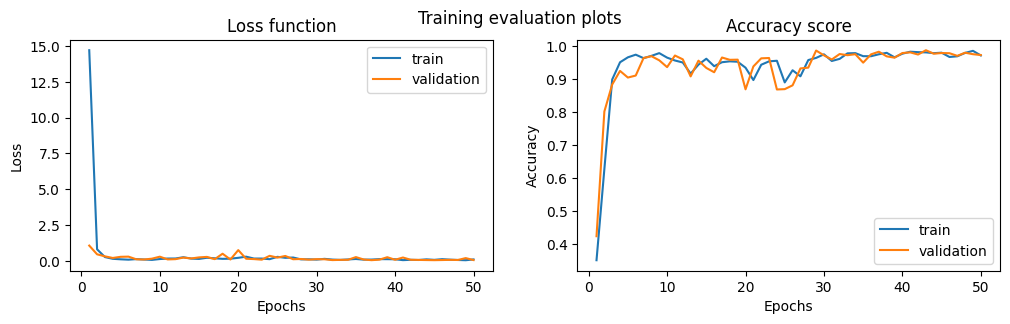

In [16]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)
torch.backends.cudnn.deterministic=True

# Initialize parameters
epochs = 50
lr = 0.01
bs = 16

# Create data loaders
train_dl, valid_dl = get_data(train_dataset, val_dataset, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

# Initialize model and use gpu if possible
model = symmetry_model_2()
model.to(dev)

opt = optim.Adam(model.parameters(), lr=lr)
loss_func = F.cross_entropy

# Fit the model
outp = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Plot the output
plot_training(outp, epochs)

# Evaluate the performance 
train_dl = DataLoader(train_dataset, 1, shuffle=False)
val_dl = DataLoader(val_dataset, 1, shuffle=False)
test_dl = DataLoader(test_dataset, 1, shuffle=False)

train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

print("Accuracy on train data", evaluate_model(model, train_dl).item())
print("Accuracy on validation data", evaluate_model(model, val_dl).item())
print("Accuracy on test data", evaluate_model(model, test_dl).item())

  2%|▏         | 1/50 [00:03<02:56,  3.60s/it]

EPOCH: 01/50 LOSS: 0.9594 ACC: 0.6787  VAL-LOSS: 0.1581 VAL-ACC: 0.9465 


  4%|▍         | 2/50 [00:06<02:31,  3.15s/it]

EPOCH: 02/50 LOSS: 0.2560 ACC: 0.9077  VAL-LOSS: 0.0557 VAL-ACC: 0.9880 


  6%|▌         | 3/50 [00:09<02:21,  3.01s/it]

EPOCH: 03/50 LOSS: 0.1845 ACC: 0.9323  VAL-LOSS: 0.0429 VAL-ACC: 0.9870 


  8%|▊         | 4/50 [00:12<02:20,  3.05s/it]

EPOCH: 04/50 LOSS: 0.1713 ACC: 0.9383  VAL-LOSS: 0.0520 VAL-ACC: 0.9835 


 10%|█         | 5/50 [00:15<02:21,  3.14s/it]

EPOCH: 05/50 LOSS: 0.1539 ACC: 0.9441  VAL-LOSS: 0.0253 VAL-ACC: 0.9950 


 12%|█▏        | 6/50 [00:18<02:17,  3.13s/it]

EPOCH: 06/50 LOSS: 0.1214 ACC: 0.9539  VAL-LOSS: 0.0348 VAL-ACC: 0.9900 


 14%|█▍        | 7/50 [00:21<02:10,  3.04s/it]

EPOCH: 07/50 LOSS: 0.1376 ACC: 0.9509  VAL-LOSS: 0.0291 VAL-ACC: 0.9935 


 16%|█▌        | 8/50 [00:24<02:04,  2.96s/it]

EPOCH: 08/50 LOSS: 0.1340 ACC: 0.9521  VAL-LOSS: 0.0207 VAL-ACC: 0.9950 


 18%|█▊        | 9/50 [00:27<02:02,  2.98s/it]

EPOCH: 09/50 LOSS: 0.1215 ACC: 0.9565  VAL-LOSS: 0.0357 VAL-ACC: 0.9895 


 20%|██        | 10/50 [00:30<02:05,  3.14s/it]

EPOCH: 10/50 LOSS: 0.1195 ACC: 0.9563  VAL-LOSS: 0.0226 VAL-ACC: 0.9930 


 22%|██▏       | 11/50 [00:33<01:59,  3.06s/it]

EPOCH: 11/50 LOSS: 0.1274 ACC: 0.9545  VAL-LOSS: 0.0291 VAL-ACC: 0.9895 


 24%|██▍       | 12/50 [00:36<01:54,  3.00s/it]

EPOCH: 12/50 LOSS: 0.1050 ACC: 0.9595  VAL-LOSS: 0.0253 VAL-ACC: 0.9950 


 26%|██▌       | 13/50 [00:39<01:49,  2.97s/it]

EPOCH: 13/50 LOSS: 0.1357 ACC: 0.9545  VAL-LOSS: 0.0199 VAL-ACC: 0.9940 


 28%|██▊       | 14/50 [00:43<01:51,  3.10s/it]

EPOCH: 14/50 LOSS: 0.0876 ACC: 0.9695  VAL-LOSS: 0.0165 VAL-ACC: 0.9965 


 30%|███       | 15/50 [00:45<01:47,  3.06s/it]

EPOCH: 15/50 LOSS: 0.1000 ACC: 0.9633  VAL-LOSS: 0.0119 VAL-ACC: 0.9975 


 32%|███▏      | 16/50 [00:48<01:42,  3.01s/it]

EPOCH: 16/50 LOSS: 0.1029 ACC: 0.9659  VAL-LOSS: 0.0187 VAL-ACC: 0.9965 


 34%|███▍      | 17/50 [00:51<01:37,  2.96s/it]

EPOCH: 17/50 LOSS: 0.0921 ACC: 0.9679  VAL-LOSS: 0.0121 VAL-ACC: 0.9985 


 36%|███▌      | 18/50 [00:55<01:43,  3.24s/it]

EPOCH: 18/50 LOSS: 0.0824 ACC: 0.9715  VAL-LOSS: 0.0157 VAL-ACC: 0.9975 


 38%|███▊      | 19/50 [00:58<01:39,  3.22s/it]

EPOCH: 19/50 LOSS: 0.0944 ACC: 0.9660  VAL-LOSS: 0.0184 VAL-ACC: 0.9970 


 40%|████      | 20/50 [01:01<01:33,  3.12s/it]

EPOCH: 20/50 LOSS: 0.0961 ACC: 0.9684  VAL-LOSS: 0.0160 VAL-ACC: 0.9965 


 42%|████▏     | 21/50 [01:04<01:28,  3.04s/it]

EPOCH: 21/50 LOSS: 0.0987 ACC: 0.9688  VAL-LOSS: 0.0176 VAL-ACC: 0.9965 


 44%|████▍     | 22/50 [01:07<01:24,  3.02s/it]

EPOCH: 22/50 LOSS: 0.0885 ACC: 0.9701  VAL-LOSS: 0.0129 VAL-ACC: 0.9970 


 46%|████▌     | 23/50 [01:10<01:25,  3.15s/it]

EPOCH: 23/50 LOSS: 0.0680 ACC: 0.9767  VAL-LOSS: 0.0130 VAL-ACC: 0.9970 


 48%|████▊     | 24/50 [01:13<01:19,  3.07s/it]

EPOCH: 24/50 LOSS: 0.0771 ACC: 0.9736  VAL-LOSS: 0.0206 VAL-ACC: 0.9920 


 50%|█████     | 25/50 [01:16<01:15,  3.01s/it]

EPOCH: 25/50 LOSS: 0.0747 ACC: 0.9732  VAL-LOSS: 0.0175 VAL-ACC: 0.9930 


 52%|█████▏    | 26/50 [01:19<01:10,  2.96s/it]

EPOCH: 26/50 LOSS: 0.0923 ACC: 0.9683  VAL-LOSS: 0.0157 VAL-ACC: 0.9955 


 54%|█████▍    | 27/50 [01:22<01:11,  3.10s/it]

EPOCH: 27/50 LOSS: 0.0934 ACC: 0.9697  VAL-LOSS: 0.0191 VAL-ACC: 0.9930 


 56%|█████▌    | 28/50 [01:25<01:07,  3.07s/it]

EPOCH: 28/50 LOSS: 0.0799 ACC: 0.9724  VAL-LOSS: 0.0178 VAL-ACC: 0.9950 


 58%|█████▊    | 29/50 [01:28<01:03,  3.01s/it]

EPOCH: 29/50 LOSS: 0.0661 ACC: 0.9763  VAL-LOSS: 0.0110 VAL-ACC: 0.9970 


 60%|██████    | 30/50 [01:31<00:59,  2.98s/it]

EPOCH: 30/50 LOSS: 0.0980 ACC: 0.9688  VAL-LOSS: 0.0116 VAL-ACC: 0.9975 


 62%|██████▏   | 31/50 [01:34<00:57,  3.04s/it]

EPOCH: 31/50 LOSS: 0.0742 ACC: 0.9748  VAL-LOSS: 0.0172 VAL-ACC: 0.9965 


 64%|██████▍   | 32/50 [01:38<00:56,  3.13s/it]

EPOCH: 32/50 LOSS: 0.0934 ACC: 0.9715  VAL-LOSS: 0.0196 VAL-ACC: 0.9950 


 66%|██████▌   | 33/50 [01:41<00:51,  3.05s/it]

EPOCH: 33/50 LOSS: 0.0729 ACC: 0.9712  VAL-LOSS: 0.0157 VAL-ACC: 0.9970 


 68%|██████▊   | 34/50 [01:43<00:47,  2.99s/it]

EPOCH: 34/50 LOSS: 0.0593 ACC: 0.9792  VAL-LOSS: 0.0129 VAL-ACC: 0.9955 


 70%|███████   | 35/50 [01:46<00:44,  2.96s/it]

EPOCH: 35/50 LOSS: 0.0799 ACC: 0.9756  VAL-LOSS: 0.0119 VAL-ACC: 0.9955 


 72%|███████▏  | 36/50 [01:50<00:44,  3.16s/it]

EPOCH: 36/50 LOSS: 0.0673 ACC: 0.9764  VAL-LOSS: 0.0122 VAL-ACC: 0.9945 


 74%|███████▍  | 37/50 [01:53<00:40,  3.08s/it]

EPOCH: 37/50 LOSS: 0.0861 ACC: 0.9727  VAL-LOSS: 0.0725 VAL-ACC: 0.9955 


 76%|███████▌  | 38/50 [01:56<00:36,  3.03s/it]

EPOCH: 38/50 LOSS: 0.0640 ACC: 0.9777  VAL-LOSS: 0.0170 VAL-ACC: 0.9965 


 78%|███████▊  | 39/50 [01:59<00:32,  2.98s/it]

EPOCH: 39/50 LOSS: 0.0837 ACC: 0.9760  VAL-LOSS: 0.1140 VAL-ACC: 0.9970 


 80%|████████  | 40/50 [02:02<00:30,  3.08s/it]

EPOCH: 40/50 LOSS: 0.0718 ACC: 0.9764  VAL-LOSS: 0.0253 VAL-ACC: 0.9940 


 82%|████████▏ | 41/50 [02:05<00:27,  3.11s/it]

EPOCH: 41/50 LOSS: 0.0737 ACC: 0.9757  VAL-LOSS: 0.0125 VAL-ACC: 0.9970 


 84%|████████▍ | 42/50 [02:08<00:24,  3.02s/it]

EPOCH: 42/50 LOSS: 0.0792 ACC: 0.9737  VAL-LOSS: 0.0128 VAL-ACC: 0.9975 


 86%|████████▌ | 43/50 [02:11<00:20,  2.96s/it]

EPOCH: 43/50 LOSS: 0.0767 ACC: 0.9763  VAL-LOSS: 0.0143 VAL-ACC: 0.9955 


 88%|████████▊ | 44/50 [02:14<00:17,  2.95s/it]

EPOCH: 44/50 LOSS: 0.0592 ACC: 0.9784  VAL-LOSS: 0.0106 VAL-ACC: 0.9980 


 90%|█████████ | 45/50 [02:17<00:15,  3.10s/it]

EPOCH: 45/50 LOSS: 0.0616 ACC: 0.9797  VAL-LOSS: 0.0087 VAL-ACC: 0.9985 


 92%|█████████▏| 46/50 [02:20<00:12,  3.02s/it]

EPOCH: 46/50 LOSS: 0.0943 ACC: 0.9717  VAL-LOSS: 0.0158 VAL-ACC: 0.9955 


 94%|█████████▍| 47/50 [02:23<00:08,  2.96s/it]

EPOCH: 47/50 LOSS: 0.0642 ACC: 0.9787  VAL-LOSS: 0.0135 VAL-ACC: 0.9970 


 96%|█████████▌| 48/50 [02:26<00:05,  2.92s/it]

EPOCH: 48/50 LOSS: 0.0702 ACC: 0.9783  VAL-LOSS: 0.0114 VAL-ACC: 0.9975 


 98%|█████████▊| 49/50 [02:29<00:03,  3.05s/it]

EPOCH: 49/50 LOSS: 0.0871 ACC: 0.9732  VAL-LOSS: 0.0101 VAL-ACC: 0.9970 


100%|██████████| 50/50 [02:32<00:00,  3.05s/it]

EPOCH: 50/50 LOSS: 0.0700 ACC: 0.9776  VAL-LOSS: 0.0116 VAL-ACC: 0.9975 


Accuracy on train data 0.9964000000000001
Accuracy on validation data 0.9975
Accuracy on test data 1.0


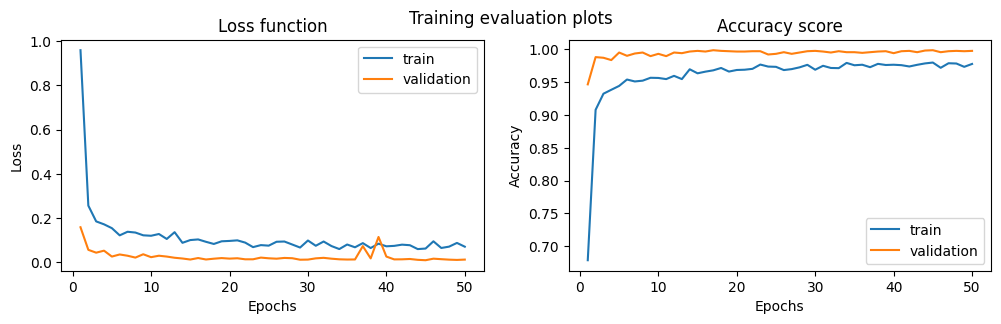

In [17]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)
torch.backends.cudnn.deterministic=True

# Initialize parameters
epochs = 50
lr = 0.01
bs = 16

# Create data loaders
train_dl, valid_dl = get_data(train_dataset, val_dataset, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

# Initialize model and use gpu if possible
model = symmetry_model_3()
model.to(dev)

opt = optim.Adam(model.parameters(), lr=lr)
loss_func = F.cross_entropy

# Fit the model
outp = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

# Plot the output
plot_training(outp, epochs)

# Evaluate the performance 
train_dl = DataLoader(train_dataset, 1, shuffle=False)
val_dl = DataLoader(val_dataset, 1, shuffle=False)
test_dl = DataLoader(test_dataset, 1, shuffle=False)

train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

print("Accuracy on train data", evaluate_model(model, train_dl).item())
print("Accuracy on validation data", evaluate_model(model, val_dl).item())
print("Accuracy on test data", evaluate_model(model, test_dl).item())

# Task 2: Carpet Matching 

In [18]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [19]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = torch.from_numpy(queries[i][None]).float().cuda()
        t = torch.from_numpy(targets[i]).float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net.forward_once(q).cpu().numpy()
            emb_t = net.forward_once(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [20]:
###     YOUR CODE FOR TASK 2    ###
from scipy.spatial.distance import cdist
import torch.nn.functional as F

class SiameseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.symslice = sc.Slice(rotation=4, reflection=False)
        self.symconv1 = sc.SymmetryConv2d(in_filters=1, out_filters=32, kernel_size=4, stride=4,\
                                         bias=True, rotation=4, reflection=False)
        self.symconv2 = sc.SymmetryConv2d(in_filters=32, out_filters=64, kernel_size=3, stride=3, \
                                         bias=True, rotation=4, reflection=False)
        self.sympool = sc.SymmetryPool(pool=torch.mean)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*8*5, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.dropout = nn.Dropout(0.5)

    def forward_once(self, x):
        x = self.symslice(x)
        x = F.relu(self.symconv1(x))
        x = F.relu(self.symconv2(x))
        x = self.sympool(x)
        x = self.batchnorm1(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
  
    def forward(self, x1, x2):
      output1 = self.forward_once(x1)
      output2 = self.forward_once(x2)
      return output1, output2

In [21]:
import random

class SiameseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self,index):
        index0 = random.randint(0, len(self.X)-1)
        dissimilar = random.randint(0,1)

        if dissimilar:
            dissimilar_indices = np.where(self.y != self.y[index0])[0]
            index1 = random.choice(dissimilar_indices)
            img0 = self.X[index0]
            img1 = self.X[index1]

        else:
            similar_indices = np.where(self.y == self.y[index0])[0]
            index1 = random.choice(similar_indices)
            img0 = self.X[index0]
            img1 = self.X[index1]
        
        return img0, img1, dissimilar
    
    def __len__(self):
        return len(self.X)

# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [22]:
def train(train_dataloader):

    loss = []
    counter = []
    iteration_number = 0
    
    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.float().cuda(), img1.float().cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()
        
        loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()

def validate(val_dataloader):
    model.eval()
    with torch.no_grad():
        loss = []
        counter = []
        iteration_number = 0
        
        # Iterate over batches
        for i, (img0, img1, label) in enumerate(val_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.float().cuda(), img1.float().cuda(), label.cuda()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)
            
            loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()

In [23]:
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = torch.from_numpy(queries[i][None]).float().cuda()
        t = torch.from_numpy(targets[i]).float().cuda()

        with torch.no_grad():
            ### MODIFY IF NECESSARY ###
            net.eval()
            emb_q = net.forward_once(q).cpu().numpy()
            emb_t = net.forward_once(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [24]:
torch.manual_seed(8)
torch.cuda.manual_seed(8)
torch.backends.cudnn.deterministic=True
random.seed(8)
np.random.seed(8)

# Split the dataset into training and validation sets
carpets = torch.Tensor(X)
labels = torch.Tensor(y)

train_size = int(0.8 * len(carpets))
train_carpets = carpets[:train_size]
train_labels = labels[:train_size]
val_carpets = carpets[train_size:]
val_labels = labels[train_size:]

train_dataset = TensorDataset(train_carpets, train_labels)
val_dataset = TensorDataset(val_carpets, val_labels)
siam_dataset_train = SiameseDataset(train_carpets, train_labels)
siam_dataset_val = SiameseDataset(val_carpets, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
siam_train_loader = DataLoader(siam_dataset_train, batch_size=32, shuffle=True)
siam_val_loader = DataLoader(siam_dataset_val, batch_size=32, shuffle=True)

# Initialize model
model2 = SiameseModel()
# model2.symslice.load_state_dict(model.symslice.state_dict())
# model2.symconv1.load_state_dict(model.symconv1.state_dict())
# model2.symconv2.load_state_dict(model.symconv2.state_dict())
# model2.sympool.load_state_dict(model.sympool.state_dict())
# model2.fc1.load_state_dict(model.fc1.state_dict())

net = model2.cuda()
criterion = ContrastiveLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr = 1e-3, weight_decay =0.0005)

train_losses = []
eval_losses = []

for epoch in range(100):
    best_eval_loss = 9999
    train_loss = train(siam_train_loader)
    eval_loss = validate(siam_val_loader)

    print(f"Training loss: {train_loss}")
    print("-"*20)

    if eval_loss<best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), "lastone.pth")

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

Training loss: 0.15702055032518175
--------------------
Training loss: 0.0035686897003385756
--------------------
Training loss: 0.0005071188866827223
--------------------
Training loss: 0.0007010897109773424
--------------------
Training loss: 0.0030047780157725014
--------------------
Training loss: 0.011830160764482286
--------------------
Training loss: 0.002759042876561483
--------------------
Training loss: 0.001330899451467726
--------------------
Training loss: 0.002404206242243449
--------------------
Training loss: 0.0014509322027630276
--------------------
Training loss: 0.0012706737037234835
--------------------
Training loss: 0.0011100666037665474
--------------------
Training loss: 0.0008199539640214708
--------------------
Training loss: 0.0006097860894203186
--------------------
Training loss: 0.0005348182871076796
--------------------
Training loss: 0.0004626488856209649
--------------------
Training loss: 0.00041282296493318346
--------------------
Training loss: 0.00

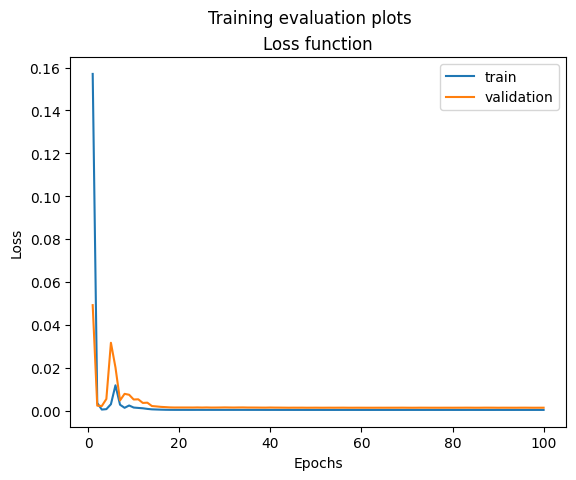

In [25]:
ep = [i+1 for i in range(len(train_losses))]
fig, ax1 = plt.subplots(1,1)
fig.suptitle("Training evaluation plots")

# Plot loss function
ax1.plot(ep, train_losses, label='train')
ax1.plot(ep, eval_losses, label='validation')
ax1.set_title('Loss function')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend();

In [26]:
# Load best model
net.load_state_dict(torch.load('lastone.pth'))

top1_accuracy = query_performance(queries, targets, gt, top=1)
print(f"Accuracy: {top1_accuracy:.2f}%")
top2_accuracy = query_performance(queries, targets, gt, top=2)
print(f"Accuracy: {top2_accuracy:.2f}%")
top3_accuracy = query_performance(queries, targets, gt, top=3)
print(f"Accuracy: {top3_accuracy:.2f}%")

Accuracy: 43.33%
Accuracy: 64.67%
Accuracy: 77.00%
